In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.utils import shuffle
import sklearn
import timeit

In [2]:
digits = load_digits()
print(digits.keys())
data = digits["data"]
target = digits["target"]
target_names = digits["target_names"]
images = digits["images"]

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [3]:
img = images[2]
assert 2 == len(img.shape)

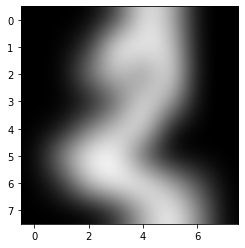

In [4]:
plt.figure ()
plt.gray ()
plt.imshow (img , interpolation ="bicubic") # also try interpolation =" bicubic "
plt.show ()

In [5]:
# split the data and the labels such as:  60% training and 40% test 
X_all = data
Y_all = target
X_train,X_test, Y_train, Y_test =\
    model_selection.train_test_split(digits.data,digits.target, test_size = 0.4,random_state=0)

In [6]:
#    Euclidean distance 
def euclidean_distance(Training, Test):
    return np.linalg.norm((Training[:,np.newaxis] - Test),axis=2)

In [7]:
print("testing Euclidean_distance on some training and test data")
training = X_train[:5]
test = X_test[100:104]
dis_matrix = euclidean_distance(training, test)
print("\n",dis_matrix)

testing Euclidean_distance on some training and test data

 [[51.89412298 47.9895822  51.54609588 27.20294102]
 [40.16217126 31.35283081 46.97871859 38.34057903]
 [51.77837386 39.73663297 40.73082371 37.92097045]
 [52.03844733 44.38468204 49.13247399 45.4202598 ]
 [48.45616576 57.44562647 38.93584467 56.16938668]]


In [8]:
print("run time of Euclidean_distance:")
%timeit dist_v = euclidean_distance(X_train, X_test)
distance = euclidean_distance(X_train, X_test)

run time of Euclidean_distance:
2.77 s ± 869 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The run time on our data here is pretty good to work with 

# K-Nearest Neighbor

In [9]:
def k_nearest_neighbor(K,Training_data,Training_targets, Test_data):
    # define a list to store neighbors
    magority = []
    # matrix of distances
    distances = euclidean_distance(Training_data,Test_data)
    neighbors = np.argsort(distances,axis = 0)[:K,:]
    labels = Training_targets[neighbors]
    for neighbor in range(labels.shape[1]):
        # check the most frequent element
        magority.append(np.argmax((np.bincount(labels[:,neighbor]))))
    return magority

In [10]:
x_train = X_train[:99]
y_train = Y_train[:99]
x_test = X_test[100:1000]
y_test =Y_test[100:1000]
k = 5
test_prediction = k_nearest_neighbor(k,x_train, y_train, x_test)

In [11]:
def error_rate(Y_test, Prediction):
    error = 0
    errors_sum =np.sum(np.where(Y_test != Prediction, error + 1, error + 0))
    errors_rate = ((errors_sum)/len(Y_test))*100
    return errors_rate

error_ = error_rate(y_test, test_prediction)
print("the error rate of our prediction is:{}% ".format(error_))

the error rate of our prediction is:18.25525040387722% 


\
The Error rate we get is not so great,\
Therefore, we will apply cross validation on KNN classifier to optimise our prediction 

In [12]:
## first we divide the dataset into k-folds
def cross_validation(Data, Target, L, K):

    
    ## shuffle data and target in the same order.
    ##example data[[1,2],[4,5],[7,8]], target [10,11,12] => after shuffle ==> data[[4,5],[7,8],[1,2]], target [11,12,10]
    data,target = sklearn.utils.shuffle(Data, Target)
    
    ## split data and targetinto L slices
    split_data = np.asarray(np.array_split(Data,L, axis = 0))
    split_target = np.array(np.array_split(Target, L))
    ## list to store errors rate of each slice prediction 
    errors = []

    ##for L slices take one slice as test and the rest as training
    for i in range(L):
            # test_data and test_targetfor a cartain slice in L
            data_test = split_data[i]
            target_test = split_target[i]
            data_train = np.concatenate([split_data[j] for j in range(L) if j != i])
            target_train = np.concatenate([split_target[j] for j in range(L) if j != i])

            slice_prediction = k_nearest_neighbor(K,data_train,target_train,data_test)
            prediction_error_rate = error_rate(target_test, slice_prediction)
            errors.append(prediction_error_rate)
            
    error_rate_mean = np.mean(errors)
    error_rate_StandardDiviation = np.std(errors)
    #print("Error rate mean is: {}%,  Error rate standard deviation is: {}%".format(error_rate_mean,error_rate_StandardDiviation))
    return error_rate_mean,error_rate_StandardDiviation

In [13]:
errors = []
L=[2,5,10]
K=[1,3,5,9,11]
for l in L:
    for k in K:
        errors.append([cross_validation(data,target,l,k)])
errors = np.reshape(np.asarray(errors),(len(errors),2))


In [14]:
df_2=pd.DataFrame(data=errors[:5], index=["K1","K3","K5","k9","k11"], columns=["mean","stddiv"])
df_2.columns=pd.MultiIndex.from_product([['F=2'],df_2.columns])
df_5=pd.DataFrame(data=errors[5:10], index=["K1","K3","K5","k9","k11"], columns=["mean","stddiv"])
df_5.columns=pd.MultiIndex.from_product([['F=5'],df_5.columns])
df_10=pd.DataFrame(data=errors[10:15], index=["K1","K3","K5","k9","k11"], columns=["mean","stddiv"])
df_10.columns=pd.MultiIndex.from_product([['F=10'],df_10.columns])#
df_ = pd.concat([df_2,df_5,df_10],axis=1)
df_

F=2                 F=5                F=10          
         mean    stddiv      mean    stddiv      mean    stddiv
K1   4.006617  0.109067  3.504952  1.286642  2.337368  1.626533
K3   4.228963  0.554130  3.337976  1.038448  2.281192  1.729775
K5   4.785570  0.331227  3.560662  0.967082  2.559590  1.879733
k9   5.508905  0.497769  4.283658  1.388178  3.338920  2.018966
k11  5.786992  0.775856  4.283813  1.144731  3.283985  2.160362

As we see in the result here , having 10 folds and 3 neighbors for comparision gives the lowest error rate!